# Plots

_Note_: If you want to ensure your figure aesthetics are the same, either manually configure the `rc` variable in the first cell or place these lines in your `~/.config/matplotlib/matplotlibrc` file:

    lines.linewidth: 2
    lines.markeredgecolor: k
    lines.markeredgewidth: 1.3
    boxplot.whiskers: 1.5
    boxplot.patchartist: True
    boxplot.showmeans: True
    boxplot.meanline: False
    boxplot.boxprops.linewidth: 1.5
    boxplot.whiskerprops.linewidth: 1.5
    boxplot.medianprops.linewidth: 1.5
    boxplot.medianprops.color: None
    boxplot.meanprops.marker: ^
    boxplot.meanprops.markerfacecolor: w
    boxplot.meanprops.markeredgecolor: k
    axes.grid: True
    axes.linewidth: 1.5
    xtick.bottom: True
    xtick.labelbottom: True
    xtick.major.width: 1.5
    xtick.minor.width: 1 
    ytick.left: True
    ytick.labelleft: True
    ytick.major.width: 1.5
    ytick.minor.width: 1 
    grid.linestyle: --
    hist.bins: auto  
    savefig.bbox: tight

In [52]:
from pathlib import Path
from typing import Iterable, Union

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

rc = mpl.rc_params_from_file(mpl.matplotlib_fname(), use_default_template=False)
sns.set_theme(style="white", rc=rc)

ROGI_KEY = "rogi"
FEATURE_LABELS = dict(
    morgan="FP", vae="VAE", gin="GIN", chemberta="ChemBERTa", chemgpt="ChemGPT"
)
CSV_DIR = Path("../results/raw/rogi/tdc+guac")

In [159]:
def disable_gridlines(ax: plt.Axes, axis: str, vals: Union[float, Iterable[float]]):
    if isinstance(vals, float):
        vals = [vals]
    vals = set(vals)

    gridlines = ax.get_xgridlines() if axis == "x" else ax.get_ygridlines()
    for line in gridlines:
        v = line.get_xdata()[0] if axis == "x" else line.get_ydata()[0]
        if v in vals:
            line.set(visible=False)
    
    return ax


def rogi_string(x: str):
    return rf"$\mathrm{{ROGI}}_{{\mathrm{{{x}}}}}$"

In [77]:
df = pd.concat(map(pd.read_csv, CSV_DIR.iterdir()), ignore_index=True)\
    .replace(*zip(*FEATURE_LABELS.items()))\
    .groupby(["features", "dataset_and_task"])\
    .agg("mean")\
    .reset_index()

FEATURES = set(df["features"].unique())
PRETRAINED_FEATURES = sorted(FEATURES - {"descriptor", "FP"})

df

,features,dataset_and_task,rogi,n_valid
0,ChemBERTa,ARIPIPRAZOLE_SIMILARITY,0.158179,10000.0
1,ChemBERTa,CACO2_WANG,0.217590,910.0
2,ChemBERTa,CELECOXIB_REDISCOVERY,0.156523,10000.0
3,ChemBERTa,CLEARANCE_HEPATOCYTE_AZ,0.446076,1213.0
4,ChemBERTa,CLEARANCE_MICROSOME_AZ,0.369319,1102.0
...,...,...,...,...
103,descriptor,PPBR_AZ,0.203476,1614.0
104,descriptor,SCAFFOLD HOP,0.084902,10000.0
105,descriptor,SOLUBILITY_AQSOLDB,0.167987,9982.0
106,descriptor,VDSS_LOMBARDO,0.046563,1130.0


## ROGI distribution boxplot

In [160]:
def boxplot(df: pd.DataFrame, x_key: str = "descriptor", x_label: str = None, ax = None):
    COLORS = sns.color_palette(None, len(PRETRAINED_FEATURES))
    JITTER = 0.1625
    
    x_label = x_label or x_key
    ax = ax or plt.gca()

    x = df.query(f"features == '{x_key}'")['rogi'].values
    ys = [df.query(f"features == '{f}'")['rogi'].values for f in PRETRAINED_FEATURES]
    Z = np.array(ys) / x - 1
    Z *= 100

    ax.boxplot(
        Z.T,
        vert=False,
        labels=PRETRAINED_FEATURES,
        widths=4 * JITTER,
        showmeans=True,
        patch_artist=True,
        boxprops=dict(fc="None"),
        medianprops=dict(c=None),
        showfliers=False,
    )

    ax.grid(which="both", axis="x", ls="--", dashes=(4, 4))

    for j in range(len(Z)):
        z = Z[j]
        y = (j + 1) + np.random.uniform(-JITTER, JITTER, z.shape)

        ax.plot(z, y, 'o', color=COLORS[j])

    ax.set_xlabel(f"Relative difference betweeen {rogi_string('*')} and {rogi_string(x_label)} (%)")
    ax.grid(False, axis='y')


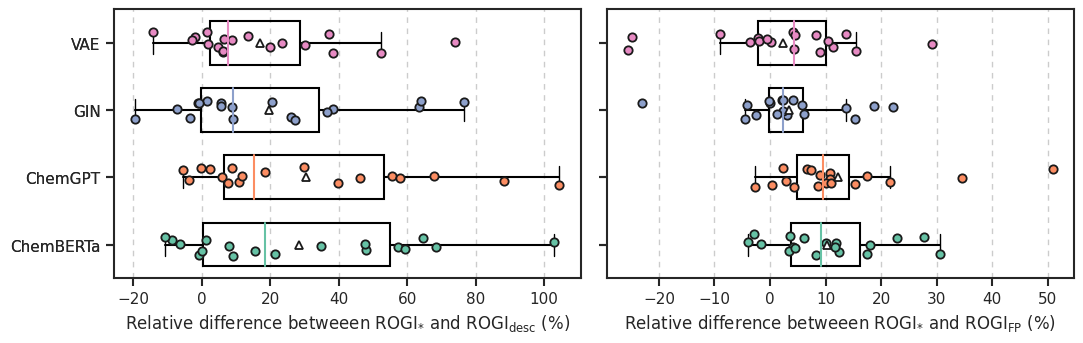

In [174]:
sns.set_palette("Set2")

fig, axs = plt.subplots(1, 2, figsize=(1 + 2 * 5, len(FEATURES) * 0.6), sharey=True)

boxplot(df, "descriptor", "desc", axs[0])
boxplot(df, "FP", None, axs[1])

fig.tight_layout()
# axs[1].sharey(axs[0])
# axs[1].set_yticklabels([])

In [173]:
axs[1].get_xgridlines()[0].get_xdata()


(-30.0,)

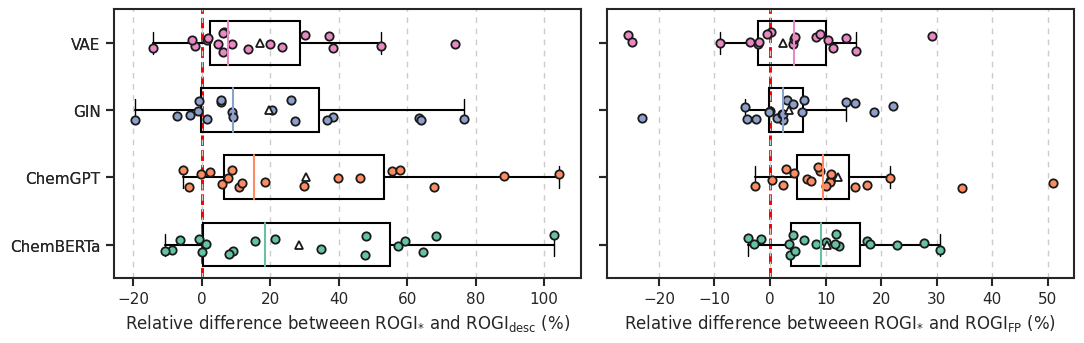

In [168]:
for ax in axs:
    # disable_gridlines(ax, "x", [0.])
    ax.axvline(0, ls="--", color="red", zorder=0, alpha=1)

fig.tight_layout()
fig

In [ ]:
fig.savefig("../results/figures/rogi-boxplot-v2.pdf", bbox_inches="tight")

## Parity plots

In [4]:
def parity_plot(
    ax: plt.Axes, df: pd.DataFrame, x_key: str, y_key: str, threshold: float = 0.1
):
    x = df.loc[x_key.lower()]["rogi"]['mean']
    y = df.loc[y_key.lower()]["rogi"]['mean']
    s = df.loc[x_key.lower()]["n_valid"]['mean'].values / 1e2
    z = (y - x) / x

    ax.scatter(x, y, s, z, vmin=-1, vmax=1, cmap="coolwarm", edgecolors='k', lw=1.3)
    ax.plot([[0, 0], [1, 1]], '--', c='grey', dashes=(4, 2.5), zorder=-1)

    roughest_dset = z.idxmax()
    i = z.index.get_loc(roughest_dset)
    # arrowprops = dict(arrowstyle="-|>,width=1", facecolor='black')
    arrowprops = dict(width=2.5, headwidth=10, shrink=0.2, facecolor='k')
    ax.annotate(
        roughest_dset,
        (x[i], y[i]),
        (0.225, 0.45),
        textcoords='data',
        ha="center",
        arrowprops=arrowprops,
        fontsize=10
    )

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    ax.set_title(y_key)

In [ ]:
desc_key = "descriptor"
features = ["VAE", "GIN", "ChemBERTa", "ChemGPT"]
N = len(features)
fig, axs = plt.subplots(1, N, figsize=(3.5 * N, 4), sharex=True, sharey=True)

for i in range(len(features)):
    ax = axs[i]
    feature = features[i]
    parity_plot(ax, df, desc_key, feature, 0.10)
    if i == 0:
        ax.set_ylabel("ROGI")

fig.supxlabel(rogi_string(desc_key))
fig.tight_layout()

In [22]:
fig.savefig(f"./results/figures/{'-'.join(features)}.pdf", bbox_inches="tight")